# Funciones para detección de espiguletas (*spiklets*)

Este cuaderno contiene funciones, graficas y pruebas para la detección automática de espiguletas.
Empezamos por cargar las bibliotecas necesarias de uso general.

In [4]:
using PyPlot, HDF5
using Statistics

El archivo adjunto **sacadatos.jl** contiene funciones para abrir y ordenar un archivo tipo *hdf5* del programa *Stimfit*.

In [5]:
include("sacadatos.jl")

devuelvedatos (generic function with 1 method)

In [6]:
nomine = "180718_9.hf5";

In [7]:
datos = h5open(nomine, "r");
names(datos)

5-element Array{String,1}:
 "Im_primaryIm_sec"
 "Im_sec"          
 "channels"        
 "comment"         
 "description"     

In [8]:
constantes, sweps = devuelvedatos(datos, "Im_primaryIm_sec");
const freq=1/constantes[1];
println("la frequencia de muestreo es ", freq, " kHz." )

la descripcion de tus barridas de datos son las siguientes
HDF5.HDF5Compound{3}[HDF5Compound{3}((0.04, "ms", "mV"), ("dt", "xunits", "yunits"), (Float64, String, String))]
la frequencia de muestreo es 25.0 kHz.


In [9]:
const prevGms=10
const postGms=40
const preG=round(Int, prevGms*freq)
const posG=round(Int, postGms*freq)

1000

Funciones auxiliares para convertir tiempo (en ms) a intervalos (en indices enteros) y viceversa:

In [10]:
function iart(i::Int,f::Int) 
  #  """function que pasa de intervalos enteros a tiempo en ms"""
aux=i:f
    result=aux./freq
end

function tari(it,ft)
    # funtion que pasa de tiempo en ms a intervalos enteros de indices
    auxi=round(Int, it*freq)
    auxf=round(Int, ft*freq)
    result=auxi:auxf
end

tari (generic function with 1 method)

Funciones de suavizado (duro y gaussiano), e.g. $ \tilde{x}= \sum_{-2}^{2} x_i /N$

In [11]:
function suaveduro(trazo::Array, nv=9)
# funcion que promedia cada punto sobre sus vecinos
    aux=trazo
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        result[j]=mean(aux[j:j+nv*2])
    end
    return result 
end


gauss(x, sigma)=exp(-(x/sigma)^2/2)

function pesosgauss(desv::Real,n::Int)
# funcion que promedia cada punto sobre sus vecinos, pero con peso gaussiano
    g=zeros(2*n+1)
    for j=-n:n
        g[j+n+1]=gauss(j,desv)
    end
    return g
end
        
function suavegauss(trazo::Array, nv=10)
    aux=trazo
    pesos=pesosgauss(nv/2,nv)
    pesoT=sum(pesos)
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        for k=0:2*nv
        result[j]+=aux[j+k]*pesos[k+1]
        end
    end
    result/=pesoT
    return result 
end

suavegauss (generic function with 2 methods)

La siguiente funcion, **intervalosP**, determina, a partir de la derivada suavizada de un trazo, los intervalos donde posiblemente hay una espiguleta o una espiga, es decir, aquellos cuya derivada es mayor a cierto umbral. 

In [12]:
function intervalosP(dtrazo::Array,thres=0.06, thres2=0.5)
    # recuerdese: dtrazo es la DERIVADA del trazo suavizado, no el trazo.
    #se recomienda usar una diferencia suavizada en dtrazo
    esunbrinco(x)=  x>thres 
    escontiguo(x,y)=(y-x)==1
    result=Dict{Int, Any}()
    preresult=Dict{Int, Array}()
    
    #=
    Este primer loop encuentra los intervalos
    de INDICES contiguos que cumplen estar
    por encima del umbral
    =#
    r=findall(esunbrinco,dtrazo)
    
    if !(isempty(r))
        k=1
        preresult[1]=[]
        for j=1:length(r)-1   
            if escontiguo(r[j], r[j+1])
                push!(preresult[k], r[j+1])
            else
                k+=1
                preresult[k]=[]
            end
         end 
    
        n=length(keys(preresult))
        println("encontramos ", n, " posibles espiguletas")
    
    else 
        println("no hay naaaaaada")
    end
    
   
    #=
    A partir del diccionario obtenido en el loop anterior:
    1) Buscamos el maximo
    2) Vemos si su valor esta debajo del segundo umbral
    3) si si, procedemos a localizar su posicion en la lista ORIGINAL de datos
    4) devolvemos una lista con todos los numeritos en ese rango de 200 antes a 800 despues
    =#
     n=length(keys(preresult))
    if n>0    
    for j in keys(preresult)
        aux=preresult[j]
        (a, lugarlista) =findmax(dtrazo[aux[1]:aux[end]])
        if a<thres2
        lugarreal=aux[lugarlista]
        # 
        
            ai=lugarreal-preG
            af=lugarreal+posG
            (ai<1) ? ai=1 : ai=ai
            (af>25000) ? af=25000 : af=af
            result[j]=ai:af
            
        else
            continue
        end
        
    end
    
    else
        println(" te dije que no hay naaaada")
    end
    
    return result
end

intervalosP (generic function with 3 methods)

In [23]:
g0(xs::Array ,d1=-71)= xs.-(xs[1]+d1) #funcion que normaliza al valor d1

g0 (generic function with 2 methods)

In [27]:
function average1(data::Dict)
    aux=0
    k=0
    for subs in keys(data)
        for j in keys(data[subs])
            rango=data[subs][j]
            valor=suaves[subs][rango]
            aux=aux.+valor
            k+=1
        end
    end
    result=aux./k
end

average1 (generic function with 1 method)

In [42]:
function separamochas(datos::Dict)
    
Limpias=Dict{String,Dict}()
Mochas=Dict{String,Dict}()
longi=preG+posG+1
    
    for subs in keys(datos)
    for j in keys(datos[subs])
        Limpias[subs]=Dict{Int, Array}()
        Mochas[subs]=Dict{Int, Array}()     
        if length(datos[subs][j])==longi
            Limpias[subs][j]=datos[subs][j]
        else
            Mochas[subs][j]=datos[subs][j]
        end
       
        if isempty(Limpias[subs])
            delete!(Limpias, subs)
        end
        
        if isempty(Mochas[subs])
            delete!(Mochas, subs)
        end
       
    end
end

result=(Limpias, Mochas)
end

separamochas (generic function with 1 method)

# A partir de aquí viene la numérica sucia: vamos a cargar todos los intervalos de un segundo que a ojo de buen cubero tienen una espiguelta.

In [14]:
sospechosas=[14,16,18,24,28,30,41,44]
ksuspect=[]
subs="section_"
for s in sospechosas
    aux=subs*"$s"
    push!(ksuspect, aux)
end
push!(ksuspect, "section_01")
push!(ksuspect, "section_02")
push!(ksuspect, "section_46")
push!(ksuspect, "section_47")

12-element Array{Any,1}:
 "section_14"
 "section_16"
 "section_18"
 "section_24"
 "section_28"
 "section_30"
 "section_41"
 "section_44"
 "section_01"
 "section_02"
 "section_46"
 "section_47"

In [15]:
suaves=Dict{String, Array}()
difss=Dict{String, Array}()
for subs in ksuspect
    suaves[subs]=suavegauss(sweps[subs])
    difss[subs]=diff(suaves[subs])
    
end


In [16]:
difss

Dict{String,Array} with 12 entries:
  "section_44" => [-0.000701868, -0.000947423, -0.00122874, -0.00153111, -0.001…
  "section_02" => [0.00223297, 0.00278049, 0.00333727, 0.00386139, 0.00464908, …
  "section_30" => [0.000993261, 0.000641315, 0.000221756, -0.000221756, -0.0009…
  "section_01" => [0.000829238, 0.000885644, 0.000879787, 0.000799179, 0.000641…
  "section_14" => [0.00305595, 0.00355903, 0.00400549, 0.00435743, 0.00458291, …
  "section_28" => [-0.00157694, -0.00124564, -0.000799179, -0.000275462, 0.0002…
  "section_41" => [-0.00160896, -0.00162842, -0.00152696, -0.00129563, -0.00094…
  "section_16" => [0.00255638, 0.00251552, 0.0025585, 0.00276846, 0.00260395, 0…
  "section_18" => [0.0, 0.0, 0.0, 0.0, -0.000341636, -0.000499569, -0.000701868…
  "section_47" => [-0.00122874, -0.00187274, -0.00233264, -0.0028104, -0.003277…
  "section_46" => [-0.000887105, -0.00103154, -0.00147283, -0.00166067, -0.0018…
  "section_24" => [-0.00247438, -0.00252437, -0.00247438, -0.00233028, -0

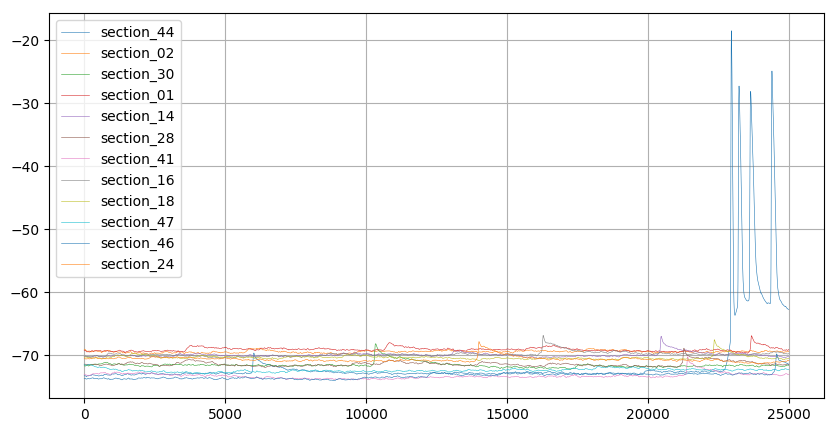

In [17]:
figura=figure(figsize=(10,5))
for subs in keys(suaves)
 plot(suaves[subs], label=subs, lw=0.4)
end
legend()
grid()

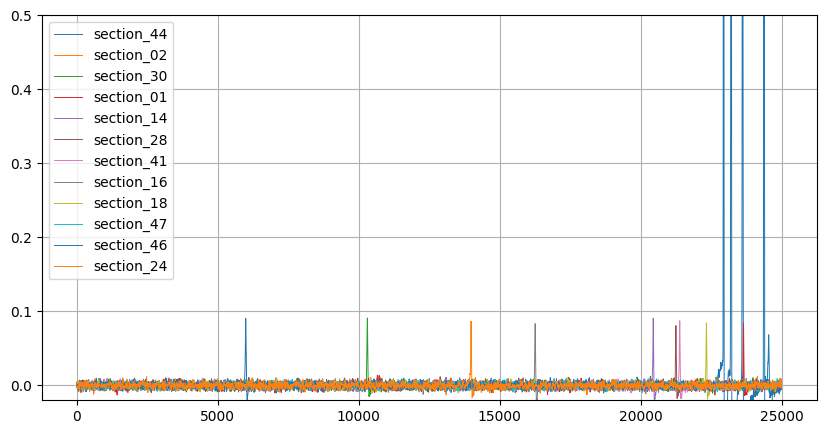

In [18]:
figura=figure(figsize=(10,5))
ylim(-0.02, 0.5)
for subs in keys(difss)
 plot(difss[subs], label=subs, lw=0.7)
end
legend()
grid()

In [19]:
intSS=Dict{String,Dict}()  #intSS es subintervalo del intervalo
for subs in keys(difss)
    println(subs)
 intSS[subs]=intervalosP(difss[subs])
end

section_44
encontramos 5 posibles espiguletas
section_02
no hay naaaaaada
 te dije que no hay naaaada
section_30
encontramos 1 posibles espiguletas
section_01
encontramos 1 posibles espiguletas
section_14
encontramos 1 posibles espiguletas
section_28
encontramos 1 posibles espiguletas
section_41
encontramos 1 posibles espiguletas
section_16
encontramos 1 posibles espiguletas
section_18
encontramos 1 posibles espiguletas
section_47
no hay naaaaaada
 te dije que no hay naaaada
section_46
encontramos 1 posibles espiguletas
section_24
encontramos 1 posibles espiguletas


In [25]:
intSS["section_46"]

Dict{Int64,Any} with 1 entry:
  1 => 24294:25000

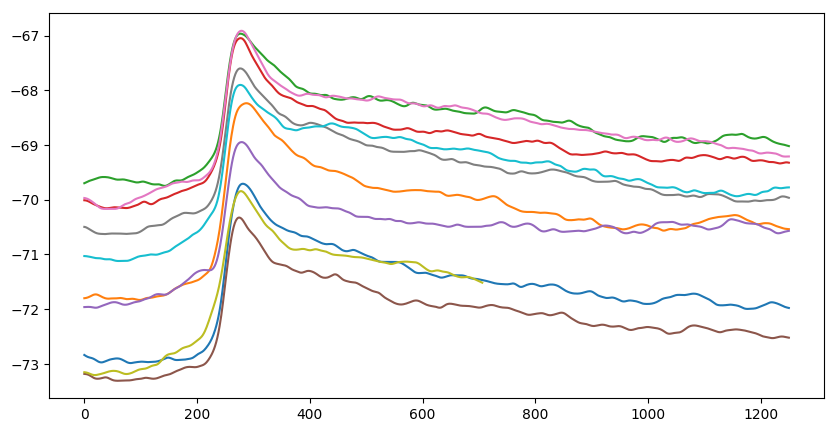

In [26]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        plot(suaves[subs][rango])
    end
end


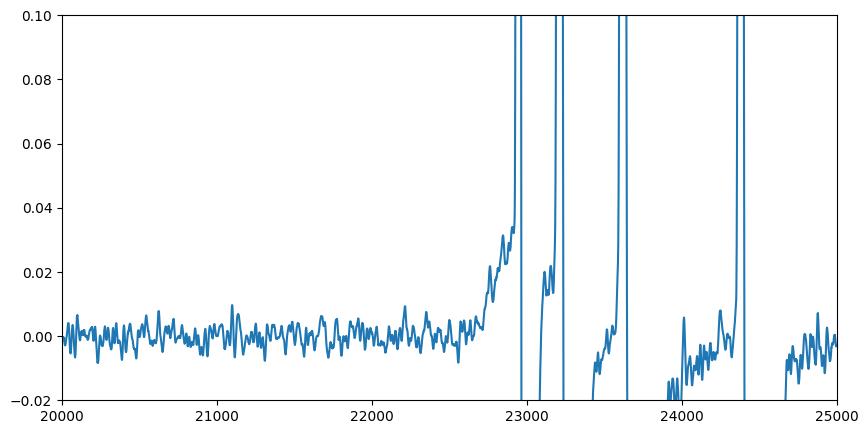

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd4d08afd30>

In [22]:
figura=figure(figsize=(10,5))
xlim(20000,25000)
ylim(-0.02,0.1)
plot(difss["section_44"])

In [43]:
(limpia, mocha)=separamochas(intSS);

In [45]:
a=average1(mocha)

707-element Array{Float64,1}:
 -73.15217783881998
 -73.15312526185903
 -73.15469563925727
 -73.15672631436959
 -73.15891961349891
 -73.16181763225121
 -73.16517435909063
 -73.16893429183301
 -73.17301040749147
 -73.1772909529741 
 -73.18164956157105
 -73.18595700981437
 -73.1900926879735 
   ⋮               
 -71.46263667195569
 -71.467194836036  
 -71.47187797511158
 -71.47649153181743
 -71.48135990813306
 -71.4864500403531 
 -71.4917049116355 
 -71.49703967586568
 -71.50234391092093
 -71.50749021293937
 -71.51212310891955
 -71.51643055716289

In [ ]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        arre=intSS[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        plot(suaves[subs][rango].-(suaves[subs][rango][1]-a[1]))
    end
end

plot(a, lw=3)

In [ ]:

figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        arre=intSS[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        plot(suaves[subs][rango].-(suaves[subs][rango][1]-a[1]), difss[subs][rango], lw=0.5)
    end
end

In [36]:
Limpias

Dict{String,Dict} with 9 entries:
  "section_16" => Dict{Int64,Array}(1=>[16009, 16010, 16011, 16012, 16013, 1601…
  "section_18" => Dict{Int64,Array}(1=>[22085, 22086, 22087, 22088, 22089, 2209…
  "section_44" => Dict{Int64,Array}(1=>[5738, 5739, 5740, 5741, 5742, 5743, 574…
  "section_14" => Dict{Int64,Array}(1=>[20198, 20199, 20200, 20201, 20202, 2020…
  "section_24" => Dict{Int64,Array}(1=>[13733, 13734, 13735, 13736, 13737, 1373…
  "section_30" => Dict{Int64,Array}(1=>[10055, 10056, 10057, 10058, 10059, 1006…
  "section_28" => Dict{Int64,Array}(1=>[21001, 21002, 21003, 21004, 21005, 2100…
  "section_01" => Dict{Int64,Array}(1=>[23400, 23401, 23402, 23403, 23404, 2340…
  "section_41" => Dict{Int64,Array}(1=>[21138, 21139, 21140, 21141, 21142, 2114…

In [37]:
Mochas

Dict{String,Dict} with 1 entry:
  "section_46" => Dict{Int64,Array}(1=>[24294, 24295, 24296, 24297, 24298, 2429…